In [1]:
# 1. 라이브러리
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# 2. 데이터 불러오기
df = pd.read_csv('labeled_reviews_lmstudio_cleaned.csv')  # 'text', 'label' 컬럼 포함

In [5]:
# 3. 전처리
df = df.dropna()  # 결측치 제거

In [7]:
# 컬럼명 확인
print(df.columns)  # 예: 'text', 'label' 확인

Index(['content', 'label', 'model_used'], dtype='object')


In [9]:
# 텍스트 전처리 함수
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
    text = re.sub(r'\d+', '', text)      # 숫자 제거
    return text.lower().strip()          # 소문자 + 공백 제거

In [11]:
# 텍스트, 라벨 분리
X = df['content'].astype(str).apply(clean_text)
y = df['label']

In [13]:
# 라벨 분포 확인
print("라벨 분포:\n", y.value_counts())

라벨 분포:
 label
2    298637
1     49560
0     20871
Name: count, dtype: int64


In [15]:
# 라벨 기준으로 데이터프레임 나누기
df_0 = df[df['label'] == 0]
df_1 = df[df['label'] == 1].sample(n=20871, random_state=42)
df_2 = df[df['label'] == 2].sample(n=20871, random_state=42)

# 세 클래스 합치기
df_balanced = pd.concat([df_0, df_1, df_2]).sample(frac=1, random_state=42).reset_index(drop=True)

# 라벨 분포 확인
print("균형 맞춘 라벨 분포:\n", df_balanced['label'].value_counts())

균형 맞춘 라벨 분포:
 label
0    20871
2    20871
1    20871
Name: count, dtype: int64


In [25]:
# 4. 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. 토크나이저
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 6. 패딩
max_len = 80
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# 7. 라벨 원핫 인코딩
num_classes = len(y.unique())  # 예: 3 (부정/중립/긍정)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

In [27]:
# 8. 모델 정의
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 9. EarlyStopping 콜백
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

C:\Users\User\anaconda3\envs\deepnlpenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
# 10. 모델 학습
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/50
3691/3691 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.8097 - loss: 0.5909 - val_accuracy: 0.8326 - val_loss: 0.4426
Epoch 2/50
3691/3691 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.8355 - loss: 0.4394 - val_accuracy: 0.8389 - val_loss: 0.4299
Epoch 3/50
3691/3691 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.8461 - loss: 0.4076 - val_accuracy: 0.8435 - val_loss: 0.4265
Epoch 4/50
3691/3691 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.8550 - loss: 0.3893 - val_accuracy: 0.8408 - val_loss: 0.4318
Epoch 5/50
3691/3691 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.8673 - loss: 0.3588 - val_accuracy: 0.8387 - val_loss: 0.4530
Epoch 6/50
3691/3691 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.8775 - loss: 0.3326 - val_accuracy: 0.8368 - val_loss: 0.4572
Epoch 7/50
3691/3691 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.8865 - loss: 0.3085 - val_accuracy: 0.8339 - val_loss: 0.4996
Epoch 8/50
3691/3691 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.8977 -

In [31]:
# 11. 평가
loss, acc = model.evaluate(X_test_pad, y_test_cat)
print(f"\n✅ 최종 테스트 정확도: {acc:.4f}")

2307/2307 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8404 - loss: 0.4311

✅ 최종 테스트 정확도: 0.8412


In [33]:
# 12. 예측
preds = model.predict(X_test_pad)
y_true = np.argmax(y_test_cat, axis=1)
y_pred = np.argmax(preds, axis=1)

2307/2307 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step


In [35]:
# 13. 시각화
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

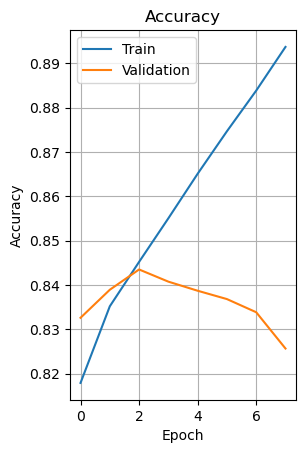

In [37]:
# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

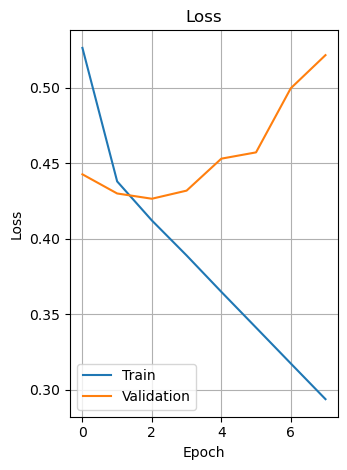

In [39]:
# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# 15. 분류 리포트
print("=== 분류 리포트 (Classification Report) ===")
print(classification_report(y_true, y_pred, target_names=['부정', '중립', '긍정']))

In [41]:
# 16. 새로운 리뷰 예측하기
def predict_sentiment(texts):
    # 전처리
    texts_clean = [clean_text(text) for text in texts]

    # 시퀀스 변환
    seq = tokenizer.texts_to_sequences(texts_clean)
    pad = pad_sequences(seq, maxlen=max_len, padding='post')

    # 예측
    preds = model.predict(pad)
    pred_labels = np.argmax(preds, axis=1)

    # 라벨 매핑
    label_map = {0: '부정', 1: '중립', 2: '긍정'}
    for text, label, confidence in zip(texts, pred_labels, np.max(preds, axis=1)):
        print(f"\n📝 리뷰: {text}")
        print(f"📌 예측 결과: {label_map[label]} ({confidence*100:.2f}% 확신)")

# 💬 예측해볼 리뷰들
new_reviews = [
    "고기 질도 좋고 직원분들 친절해서 기분 좋게 식사했어요.",
    "반찬 하나하나 정성이 느껴지고, 국물 맛도 깊어요.",
    "웨이팅 있었지만 기다릴만한 맛이었어요. 또 방문하고 싶네요.",
    "분위기도 좋고 양도 넉넉해서 데이트 코스로 최고였어요.",
    "불맛이 진하게 나서 볶음밥이 정말 맛있었어요. 강추합니다.",
    "맛은 무난했어요. 특별히 인상적이진 않았지만 나쁘지 않았습니다.",
    "친구랑 갔는데 조용해서 대화하기 좋았어요. 음식은 보통이에요.",
    "직원분이 조금 바빠보이긴 했지만 전반적으로 나쁘진 않았어요.",
    "가격이 조금 있는 편인데, 양은 적당했어요. 재방문은 고민 중.",
    "음식 나오기까지 시간이 좀 걸렸지만, 가게는 청결했어요.",
    "고기에서 누린내가 나서 거의 못 먹었어요. 비위 상했습니다.",
    "주문한 음식이 하나 빠졌는데 직원이 계속 미루기만 했어요.",
    "사진 보고 기대했는데 현실은 너무 달라서 실망이에요.",
    "국물 맛이 너무 밍밍하고 재료도 신선하지 않은 느낌이었어요.",
    "자리도 좁고 소음도 심해서 제대로 식사하기 힘들었어요.",
    "진짜 맛없고 최악이었어요.",
    "그냥 그랬어요. 무난한 편이에요.",
    "진짜 존맛탱!! 또 올 거예요~",
    "서비스는 별로였지만 음식은 괜찮았어요.",
    "위생 상태가 좀 의심스럽네요.",
    "오래 기다렸지만 맛있어요",
    "파 분명히 빼달라고 요청했는데 고의인지 실수인진 모르겠지만 결국에 넣으셨더라고요 사람 말 좀 제대로 들어주세요 맛은 맛있어요",
    "늦은시간 저녁이라 터미널 앞 김밥천국 24시간 하는곳으로 방문했습니다 메뉴판에 정말 다양한 메뉴들이 있었습니다 테이블도 많고 혼밥하시는 분들을 위한 자리도 많이 있어요 음식도 빨리 나오고 하나 같이 다 먹음직스럽게 생겼어요 여기는 다른지점에 거의 못본 곱배기도 있더라구요 너무 많이 시켜서 라볶이는 좀 남기긴 했지만 잘 먹고 왔어요 여기는 늦은시간에 오시는 손님도 정말 많지만 배달이 정말 많더라구요 음식들이 다 평타이상이라 뭘 시켜도 믿고 먹을수 있을거 같아요",
    "리모델링하고는 처음 가보네요 비슷한데 깔끔해지고 끝이 벽 보게 바뀌었네요 정수기 위치도 바뀌고 주방 위쪽에 일부 메뉴들 써있네요 참치김밥 주문했어요 5천원이에요 이렇게 비싼줄 몰랐네요ㅠ 일반만 3천인가 3500인가 그렇고 나머진 4500부터 시작이네요 김밥만 드실거면 선불이에요 깻잎에 참치 싸져있고 당근 우엉 햄 단무지 계란 들어가요 깻잎이 들어가서 그런가 오이나 시금치는 없네요 겉에 깨 조금 뿌려져있어요 전엔 엄청 맛있었는데 이번엔 그냥 맛있는 정도? 참치 양도 적어진 것 같은 느낌",
    "솔직히 김밥천국은 점바점이 강하잖아요..🥹 어딘 맛있는데 어딘 맛없고..그리고 불친절하거나 위생적이지 못한 곳도 많고해서 방문을 잘안했는데 청주터미널점은 김밥천국중에서도 제일 맛있고 친절하셔서 넘 좋더라고요~💖 그래서 그런가 늦은시간임에도 불구하고 식사하시는 손님들이 엄청 많았는데요, 시킨 메뉴 하나하나 다 맛있어서 놀랐답니다👍🏻👍🏻역시 그래서 그런지 배달이랑 포장주문도 많은데 바쁜데도 직원분들이 짜증한번 안내시고 친절하게 응대해주셔서 좋았어요🥰 학생들이 와서 김밥에 재료를 빼달라고 까다롭게 요청하는데도 짜증없이 친절하게 응대해주시고..🥹진짜 24시간인 점도 정말 좋고 김밥천국 생각날때는 집에서는 멀긴하지만 일부러 청주터미널점에 방문하고 싶을정도로 제가 방문했던 김밥천국 중 맛도 친절도 최고였답니다👍🏻👍🏻",
    "공사하고 깨끗해졌어요 항상 사람이 많아요.가성비 좋고 메뉴도 많아서 여러 명 가서 같이 먹어요.",
    "쫄면. 면이랑 콩나물이 너무 아삭? 해서 ㅠ.ㅠ",
    "늦은시간 한끼먹기에 좋음 역시 김천은 정식이 필수지...제육덮밥은 너무 짬. 리모델링끝났길래 다녀왔는데 음식가격이 올랐네.....쩝",
    "우선 커피가 예술이에요~청주에서 보기드문 고퀄커피맛이에요~정말 커피에 진심인 곳 같아요~디저트류는 거의 없고 커피에 주력하시는 거 같아요~커피 진짜 최고에요~분위기랑 인테리어도 너무 좋아서 다시 한번 더 방문하고픈 카페에요~",
    "어렸을 적 할머니가 사시던 외갓집이 이런 분위기였어요. 벽과 천장이 나무로 되어 있어 따스한 곳이요. 창에 드리운 햇살과 음악, 커피의 조화 ... 더없이 평온했어요 ☕ 작가들의 핸드메이드 제품들이 곳곳에 있어 요모조모 살펴보기도 좋고 선물하기 좋은 제품들이 있어 몇가지 구매하고갑니다 ! 카페와 편집숍이 조화롭게 어울려 있어 좋았고 매 달 나오는 이 곳만의 소식지가 있었어요. 이야기 있는 이 공간에 다시 발걸음 하고 싶어요 😍",
    "😡😡😡😠😠😠",
    "😢😢😢💢"
]


predict_sentiment(new_reviews)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

📝 리뷰: 고기 질도 좋고 직원분들 친절해서 기분 좋게 식사했어요.
📌 예측 결과: 긍정 (96.85% 확신)

📝 리뷰: 반찬 하나하나 정성이 느껴지고, 국물 맛도 깊어요.
📌 예측 결과: 긍정 (96.90% 확신)

📝 리뷰: 웨이팅 있었지만 기다릴만한 맛이었어요. 또 방문하고 싶네요.
📌 예측 결과: 중립 (53.96% 확신)

📝 리뷰: 분위기도 좋고 양도 넉넉해서 데이트 코스로 최고였어요.
📌 예측 결과: 긍정 (96.12% 확신)

📝 리뷰: 불맛이 진하게 나서 볶음밥이 정말 맛있었어요. 강추합니다.
📌 예측 결과: 긍정 (97.37% 확신)

📝 리뷰: 맛은 무난했어요. 특별히 인상적이진 않았지만 나쁘지 않았습니다.
📌 예측 결과: 중립 (52.07% 확신)

📝 리뷰: 친구랑 갔는데 조용해서 대화하기 좋았어요. 음식은 보통이에요.
📌 예측 결과: 긍정 (58.89% 확신)

📝 리뷰: 직원분이 조금 바빠보이긴 했지만 전반적으로 나쁘진 않았어요.
📌 예측 결과: 중립 (55.09% 확신)

📝 리뷰: 가격이 조금 있는 편인데, 양은 적당했어요. 재방문은 고민 중.
📌 예측 결과: 중립 (51.86% 확신)

📝 리뷰: 음식 나오기까지 시간이 좀 걸렸지만, 가게는 청결했어요.
📌 예측 결과: 부정 (46.68% 확신)

📝 리뷰: 고기에서 누린내가 나서 거의 못 먹었어요. 비위 상했습니다.
📌 예측 결과: 부정 (72.89% 확신)

📝 리뷰: 주문한 음식이 하나 빠졌는데 직원이 계속 미루기만 했어요.
📌 예측 결과: 중립 (40.29% 확신)

📝 리뷰: 사진 보고 기대했는데 현실은 너무 달라서 실망이에요.
📌 예측 결과: 긍정 (57.46% 확신)

📝 리뷰: 국물 맛이 너무 밍밍하고 재료도 신선하지 않은 느낌이었어요.
📌 예측 결과: 부정 (75.05% 확신)

📝 리뷰: 자리도 좁고 소음도 심해서 제대로 식사하기 힘들었어요.
📌 예측 결과: 부정 (49.88% 확신)

📝 

In [43]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [45]:
# 확률 예측 → 클래스 예측
y_pred_proba = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_proba, axis=1)

# 실제 정답
y_true = np.argmax(y_test_cat, axis=1)

2307/2307 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


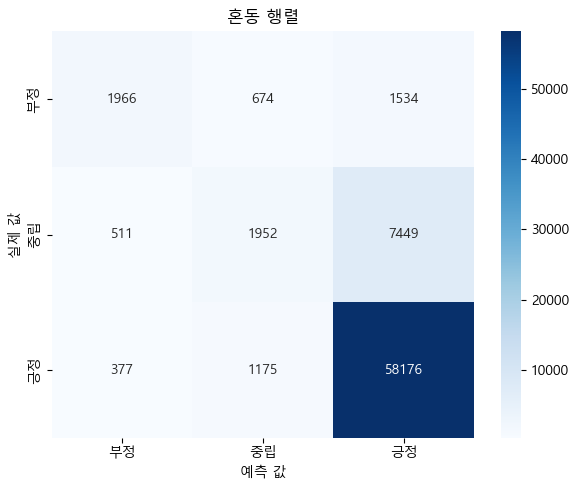

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.font_manager as fm

# ✅ 한글 폰트 설정 (윈도우 기준 예시: 'Malgun Gothic')
plt.rc('font', family='Malgun Gothic')       # Windows
# plt.rc('font', family='AppleGothic')       # macOS
plt.rcParams['axes.unicode_minus'] = False   # 음수 기호 깨짐 방지

# ✅ 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)

# ✅ 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['부정', '중립', '긍정'],
            yticklabels=['부정', '중립', '긍정'])
plt.xlabel('예측 값')
plt.ylabel('실제 값')
plt.title('혼동 행렬')
plt.tight_layout()
plt.show()


In [49]:
print("\n📋 Classification Report")
print(classification_report(y_true, y_pred, target_names=['부정', '중립', '긍정']))


📋 Classification Report
              precision    recall  f1-score   support

          부정       0.69      0.47      0.56      4174
          중립       0.51      0.20      0.28      9912
          긍정       0.87      0.97      0.92     59728

    accuracy                           0.84     73814
   macro avg       0.69      0.55      0.59     73814
weighted avg       0.81      0.84      0.81     73814



In [1]:
# 16. 모델 저장
model.save("lstm_sentiment_model.h5")

NameError: name 'model' is not defined